# Julia

As languages go, [installing Julia](http://julialang.org/downloads/platform.html) is a piece of cake. You also need [IJulia](https://github.com/JuliaLang/IJulia.jl) to run this notebook. You will also need to instal the PyPlot package, ToeplitzMatrices and MultivariateStats:

    Pkg.add("PyPlot")
    Pkg.add("MultivariateStats")
    Pkg.clone("https://github.com/JuliaMatrices/ToeplitzMatrices.jl.git")

I'm using Julia v0.5. 

## Basic example

[Basic array help.](http://docs.julialang.org/en/release-0.5/manual/arrays/)

[The linalg help is here.](http://docs.julialang.org/en/release-0.5/stdlib/linalg/)

In [1]:
using PyPlot

INFO: Recompiling stale cache file /home/castaned/.julia/lib/v0.5/PyCall.ji for module PyCall.
INFO: Recompiling stale cache file /home/castaned/.julia/lib/v0.5/PyPlot.ji for module PyPlot.


In [2]:
function norm(m)
    return m' * m
end

function misfit(d, d_pred)
    misfit = (d_pred .- d)' * (d_pred .- d)
    return misfit[1]
end

misfit (generic function with 1 method)

In [3]:
function plot_all(m, d, m_est, d_pred)
    #=
    Helper function for plotting. You can ignore this.
    =#
    
    fig = figure(figsize=(10,6))

    ax0 = fig[:add_subplot](2,2,1)
    ax0[:plot](m)
    t = L"$\mathrm{Model}$"
    ax0[:set_title](t)
    ax0_mi, ax0_ma = ax0[:get_ylim]()

    ax1 = fig[:add_subplot](2,2,2)
    ax1[:plot](d, "o", mew=0)
    ax1[:set_title](L"$\mathrm{Data}\ d$")
    ax1_mi, ax1_ma = ax1[:get_ylim]()
    
    ax2 = fig[:add_subplot](2,2,3)
    ax2[:plot](m, alpha=0.25)
    ax2[:plot](m_est)
    t = L"$\mathrm{Estimated\, model}$"
    ax2[:set_title](t)
    ax2_mi, ax2_ma = ax2[:get_ylim]()
    
    ax3 = fig[:add_subplot](2,2,4)
    ax3[:plot](d, "o", mew=0, alpha=0.25)
    ax3[:plot](d_pred, "o", mew=0)
    t = L"$\mathrm{{Predicted\ data}}$"
    ax3[:set_title](t)
    ax3_mi, ax3_ma = ax3[:get_ylim]()
    

end

plot_all (generic function with 1 method)

We can add a user made library to generate Toeplitz matrices: Pkg.clone("https://github.com/JuliaMatrices/ToeplitzMatrices.jl.git")

In [4]:
using ToeplitzMatrices
function convmtx(h, n)
    #=
    Equivalent of MATLAB's convmtx function, http://www.mathworks.com/help/signal/ref/convmtx.html.
    
    Makes the convolution matrix, C. The product C.x is the convolution of h and x.
    
    Args
        h (ndarray): a 1D array, the kernel.
        n (int): the number of rows to make.
        
    Returns
        ndarray. Size m+n-1
    =#
    col_1 = append!([h[1]],zeros(n-1))
    row_1 = append!(h,zeros(n-1))
    return Toeplitz(col_1, row_1)
end

convmtx (generic function with 1 method)

In [5]:
# Implements bruges's ricker.
function ricker(f=25, length=0.128, dt=0.001)

    # Time basis.
    t = collect(0:dt:length) .- length/2
    
    # Amplitudes.
    x = 1 - 2 * pi * f^2 .* t.^2
    y = exp(-pi^2 * f^2 .* t.^2)
    a = x .* y

    return t, a
end

ricker (generic function with 4 methods)

## Construct the model

In [6]:
M = 50

#                        VP    RHO
m_ = ones((M, 1)) * 2550 * 2650  
m_[11:15,:] =          2700 * 2750   
m_[16:27,:] =          2400 * 2450
m_[28:35,:] =          2800 * 3000

8400000

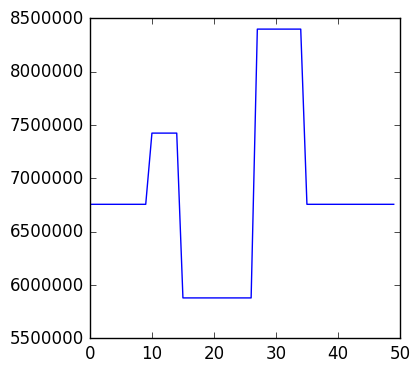

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f97ff22c5f8>

In [7]:
figure(figsize=(4,4))
plot(m_)

In [8]:
ε = 1e-9; # Small float to avoid division by zero.
m = (m_[2:end] .- m_[1:end-1]) ./ (m_[2:end] .+ m_[1:end-1] .+ ε); 

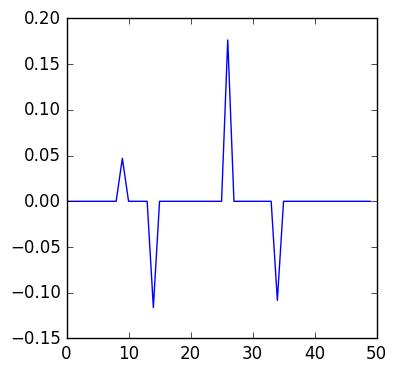

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f97ff73a240>

In [9]:
m = append!(m, 0)
figure(figsize=(4,4))
plot(m)

## Forward operator: convolution with wavelet

Now we make the kernel matrix *G*, which represents convolution.

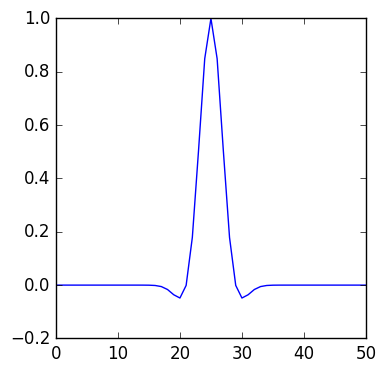

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f97fce62978>

In [10]:
t, w_ = ricker(100, 0.05, 0.001)
figure(figsize=(4,4))
plot(w_)

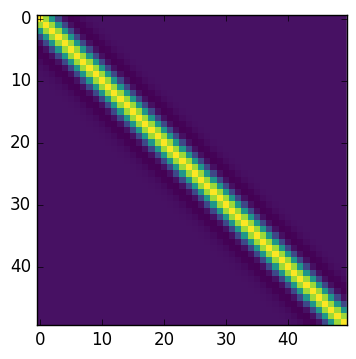

PyObject <matplotlib.image.AxesImage object at 0x7f97fce42e48>

In [11]:
G = convmtx(w_, size(m)[1])[:, 26:75]
figure(figsize=(4,4))
imshow(G,cmap="viridis", interpolation="none")

In [35]:
d = G * m;

## The problem looks like this:

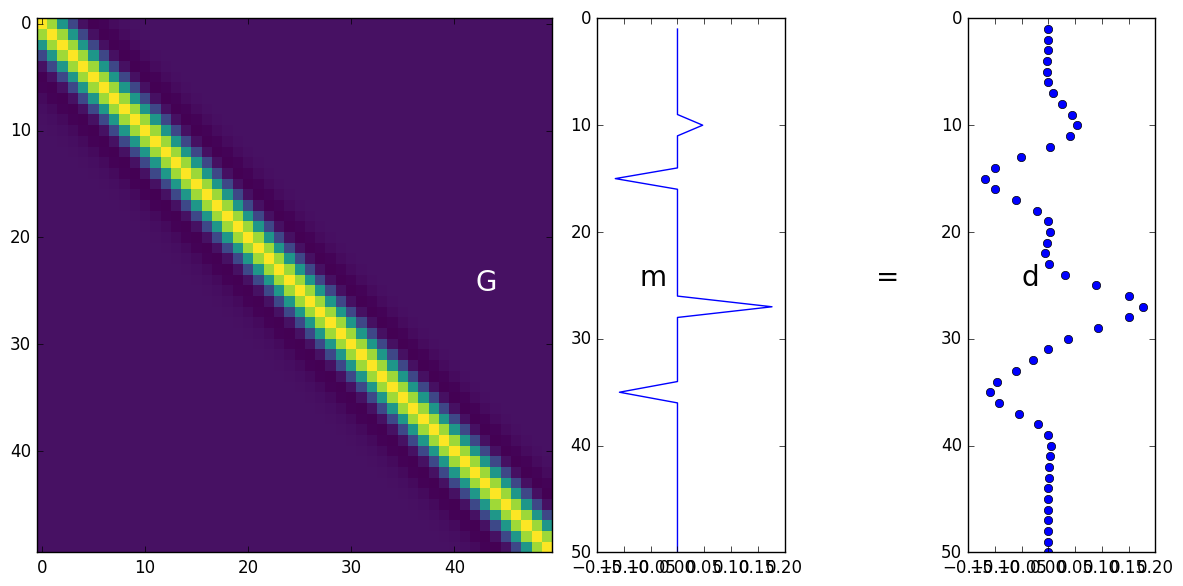

In [36]:
using PyCall
@pyimport matplotlib.gridspec as gridspec

fig = figure(figsize=(12, 6))

gs = gridspec.GridSpec(1, 4,width_ratios=[5.5, 2, 1, 2])

ax0 = subplot(get(gs, (0)))
ax0[:imshow](G, cmap="viridis", interpolation="none", aspect="auto")
ax0[:text](42, 25, "G", color="w", size=20)

y = collect(1:50)

ax1 = subplot(get(gs, (1)))
ax1[:plot](m, y)
ax1[:text](-0.07, 25, "m", color="k", size=20)
ax1[:invert_yaxis]()

ax2 = subplot(get(gs, (2)))
ax2[:set_frame_on](false)
ax2[:set_xticks]([])
ax2[:set_yticks]([])
ax2[:text](0.5, 0.5, "=", color="k", size=20)

ax3 = subplot(get(gs, (3)))
ax3[:plot](d, y, "o")
ax3[:text](-0.05, 25, "d", color="k", size=20)
ax3[:invert_yaxis]()

fig[:tight_layout]()


## Noise free: minimum norm

In [37]:
m_est = G' * inv(G * G') * d
d_pred = G * m_est;

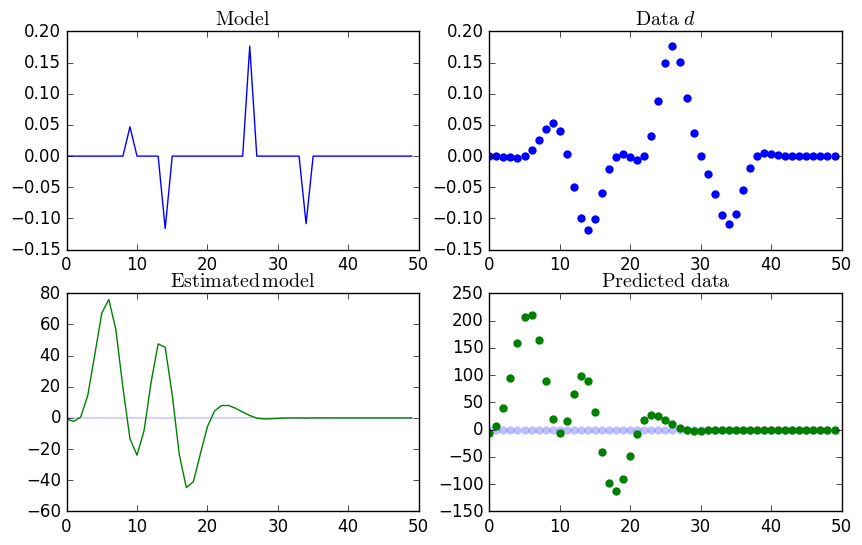

(-150.0,250.0)

In [38]:
plot_all(m, d, m_est, d_pred)

# We can use Julia's linalg "[Backlash](http://docs.julialang.org/en/release-0.5/stdlib/linalg/#Base.\)" operator to solve the system. The operation `A \ B = x` is such that `A*x == B` when `A` is square

In [39]:
m_est = G \ d 
d_pred = G * m_est;

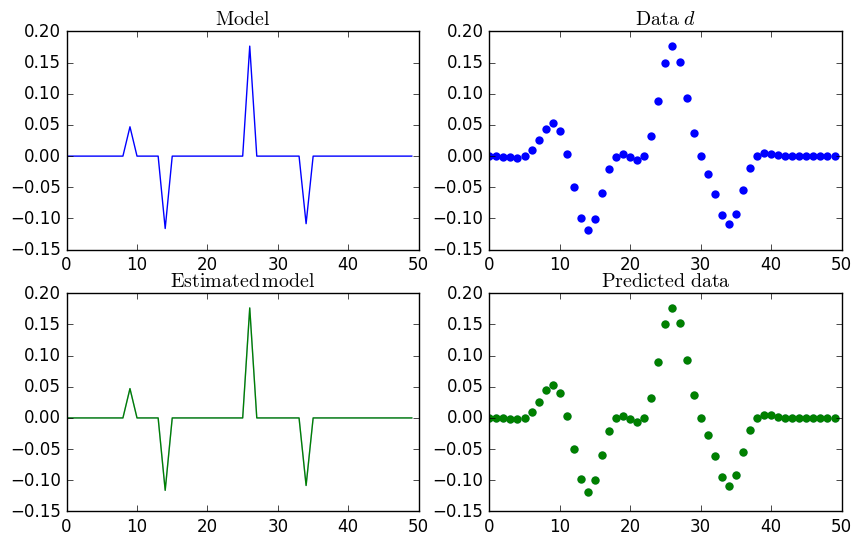

(-0.15000000000000002,0.2)

In [40]:
plot_all(m, d, m_est, d_pred)

### QR factorization

In [41]:
F = qrfact(G)

Base.LinAlg.QRCompactWY{Float64,Array{Float64,2}}([-1.41822 -1.56464 … -9.63047e-47 -6.30865e-49; 0.351122 -0.53313 … -3.04465e-44 -2.54337e-46; … ; 0.0 0.0 … -0.000189355 -0.00101375; 0.0 0.0 … -0.46447 2.06292e-5],[1.70511 -1.07541 … 0.198499 0.0; 5.45353e-312 1.28602 … 0.13531 0.0; … ; 0.0 0.0 … NaN 6.90075e-316; 0.0 0.0 … NaN 6.93175e-310])

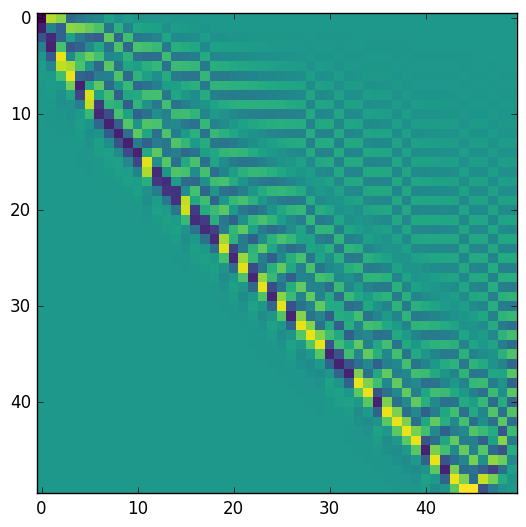

PyObject <matplotlib.image.AxesImage object at 0x7f97f6412e48>

In [42]:
imshow(F[:Q], cmap="viridis", interpolation="none")

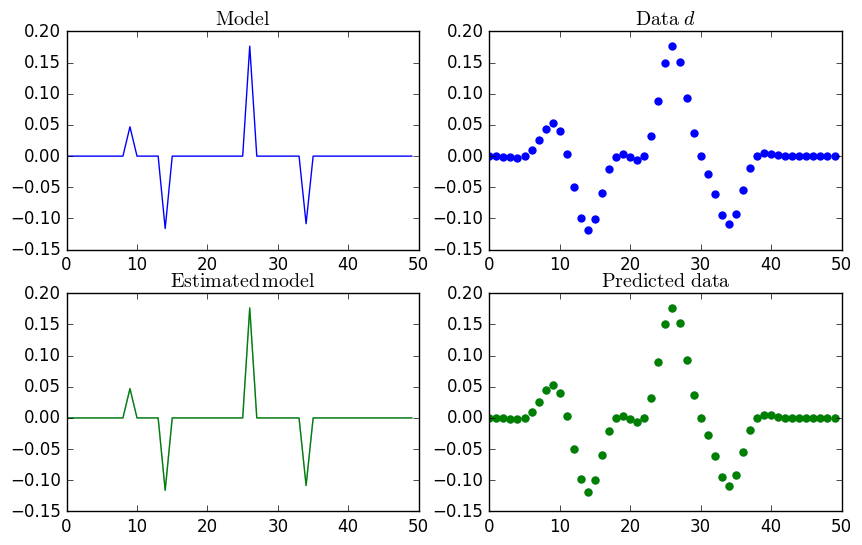

(-0.15000000000000002,0.2)

In [43]:
p = F[:Q]' * d
m_est = inv(F[:R]) * p
d_pred = G * m_est
plot_all(m, d, m_est, d_pred)

### LU Factorization

In [44]:
F = lufact(G)

Base.LinAlg.LU{Float64,Array{Float64,2}}([1.0 0.849091 … 0.0 0.0; 0.504475 0.420746 … 0.0 0.0; … ; 0.0 0.0 … 0.000473502 0.00254811; 0.0 0.0 … -0.735609 7.5219e-5],Int32[1,3,5,7,5,9,11,9,13,10  …  45,46,48,45,49,48,50,50,49,50],0)

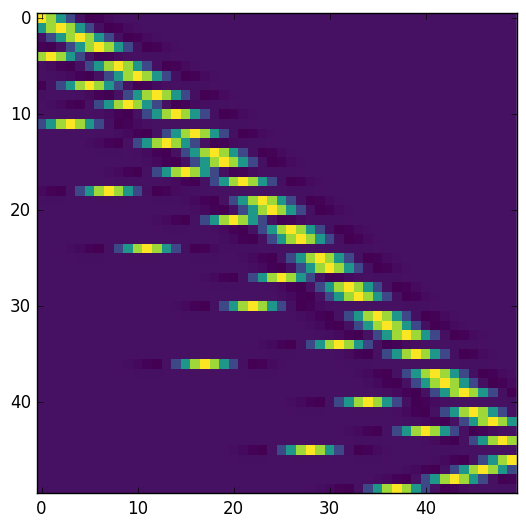

PyObject <matplotlib.image.AxesImage object at 0x7f97f6290f28>

In [45]:
imshow(F[:L]*F[:U], cmap="viridis", interpolation="none")

And solution coming next...

### Add some noise

In [46]:
s = 0.025
d = G * m + s * (rand(size(d)) - 0.5);

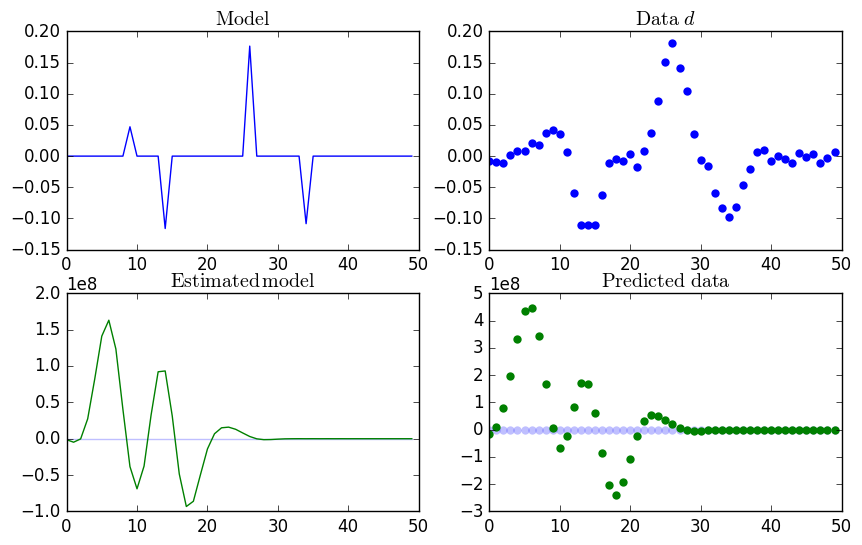

(-3.0e8,5.0e8)

In [47]:
m_est = G' * inv(G * G') * d
d_pred = G * m_est

plot_all(m, d, m_est, d_pred)

Now use Mauricio's second form:

In [48]:
I = eye(size(G)[1])
µ = 2.5
m_est = G' * inv(G * G' .+ µ * I) * d
d_pred = G * m_est;

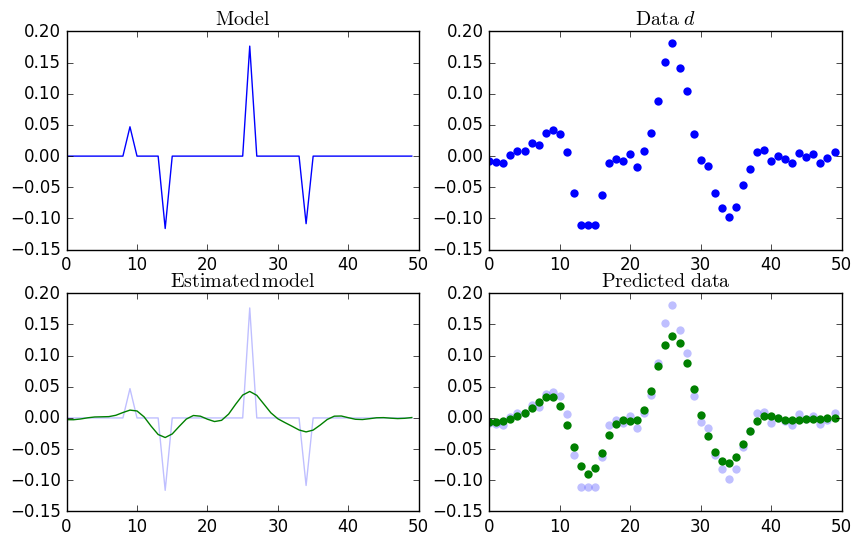

(-0.15000000000000002,0.2)

In [49]:
plot_all(m, d, m_est, d_pred)

### Regression methods
### [Least Squares](http://multivariatestatsjl.readthedocs.io/en/latest/lreg.html#ridge-regression)

In [50]:
using MultivariateStats

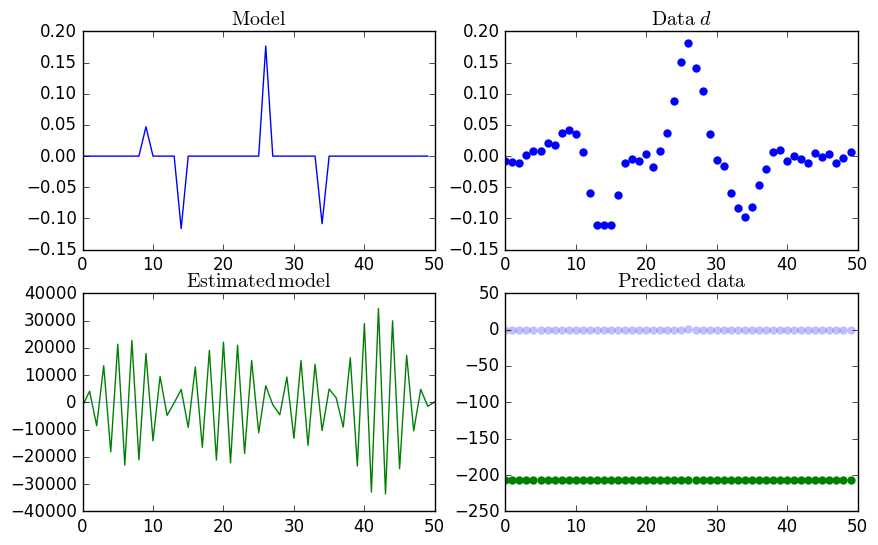

(-250.0,50.0)

In [51]:
m_est = llsq(G,d);
d_pred = G * m_est[1:end-1];
plot_all(m, d, m_est, d_pred)

### Using regression methods
### [Ridge](http://multivariatestatsjl.readthedocs.io/en/latest/lreg.html#ridge-regression)

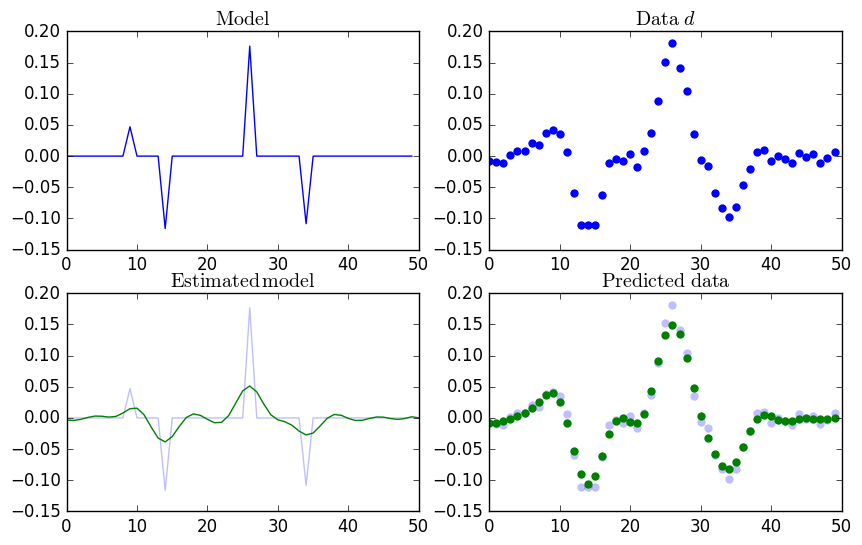

(-0.15000000000000002,0.2)

In [52]:
m_est = ridge(G,d,1);
d_pred = G * m_est[1:end-1];
plot_all(m, d, m_est, d_pred)